In [1]:
import gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# defniing Dueling DQN Network
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        return value + advantage - advantage.mean(dim=1, keepdim=True)


In [3]:
#defining replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return (
            np.array(state),
            np.array(action),
            np.array(reward),
            np.array(next_state),
            np.array(done)
        )

    def __len__(self):
        return len(self.buffer)

In [4]:
# defining step agent
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.action_dim = action_dim
        self.gamma = 0.99
        self.batch_size = 64
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.lr = 1e-3
        self.memory = ReplayBuffer(10000)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DuelingDQN(state_dim, action_dim).to(self.device)
        self.target_net = DuelingDQN(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        self.update_target()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.policy_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        current_q_values = self.policy_net(states).gather(1, actions)
        loss = F.mse_loss(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [6]:
#defining train agent
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)
num_episodes = 500
target_update_freq = 10
reward_history = []

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward

    reward_history.append(episode_reward)

    if episode % target_update_freq == 0:
        agent.update_target()

    print(f"Episode {episode}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.2f}")

env.close()


Episode 0, Reward: 73.0, Epsilon: 0.95
Episode 1, Reward: 29.0, Epsilon: 0.82
Episode 2, Reward: 33.0, Epsilon: 0.70
Episode 3, Reward: 9.0, Epsilon: 0.67
Episode 4, Reward: 18.0, Epsilon: 0.61
Episode 5, Reward: 49.0, Epsilon: 0.48
Episode 6, Reward: 8.0, Epsilon: 0.46
Episode 7, Reward: 16.0, Epsilon: 0.42
Episode 8, Reward: 9.0, Epsilon: 0.40
Episode 9, Reward: 10.0, Epsilon: 0.38
Episode 10, Reward: 11.0, Epsilon: 0.36
Episode 11, Reward: 14.0, Epsilon: 0.34
Episode 12, Reward: 26.0, Epsilon: 0.30
Episode 13, Reward: 73.0, Epsilon: 0.21
Episode 14, Reward: 47.0, Epsilon: 0.16
Episode 15, Reward: 55.0, Epsilon: 0.12
Episode 16, Reward: 64.0, Epsilon: 0.09
Episode 17, Reward: 49.0, Epsilon: 0.07
Episode 18, Reward: 56.0, Epsilon: 0.05
Episode 19, Reward: 56.0, Epsilon: 0.04
Episode 20, Reward: 35.0, Epsilon: 0.03
Episode 21, Reward: 32.0, Epsilon: 0.03
Episode 22, Reward: 33.0, Epsilon: 0.02
Episode 23, Reward: 48.0, Epsilon: 0.02
Episode 24, Reward: 48.0, Epsilon: 0.01
Episode 25, R

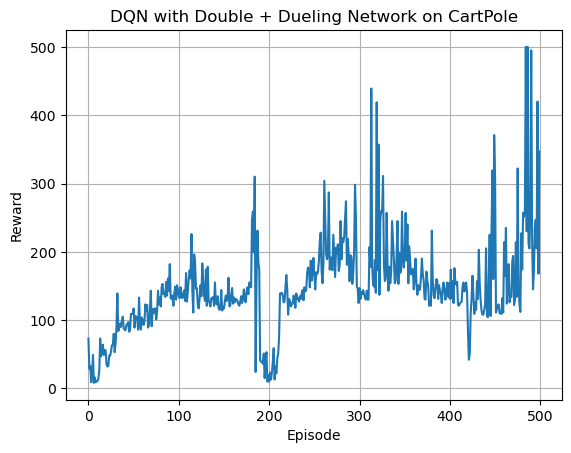

In [7]:
#plotting
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN with Double and Dueling Network on CartPole")
plt.grid()
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

rewards = reward_history 
window = 20

moving_avg = np.convolve(rewards, np.ones(window) / window, mode='valid')

reward_variance = [
    np.var(rewards[max(0, i - window):i + 1])
    for i in range(len(rewards))
]

plt.figure(figsize=(14, 10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

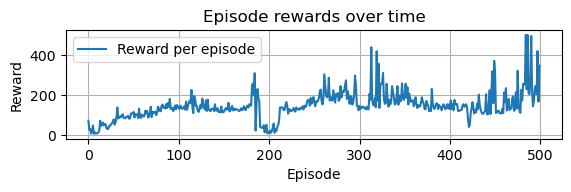

In [12]:
# Raw rewards
plt.subplot(3, 1, 1)
plt.plot(rewards, label='Reward per episode')
plt.title("Episode rewards over time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()

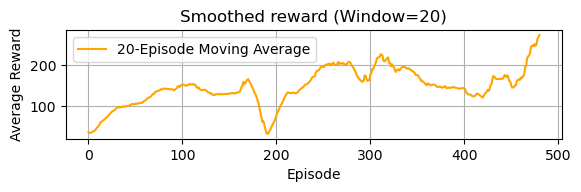

In [13]:
#Moving average
plt.subplot(3, 1, 2)
plt.plot(moving_avg, color='orange', label=f"{window}-Episode Moving Average")
plt.title(f"Smoothed reward (Window={window})")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)
plt.legend()

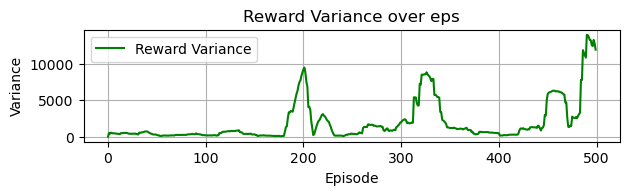

In [14]:
# reward variance
plt.subplot(3, 1, 3)
plt.plot(reward_variance, color='green', label="Reward Variance")
plt.title("Reward Variance over eps")
plt.xlabel("Episode")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()